In [1]:
%matplotlib inline
import random_forest as rf
import np_segment as nps
import numpy as np
import os
import matplotlib.pyplot as plt
from glob import glob
from skimage import io
from sklearn.externals import joblib
import pandas as pd
from slid_window import sliding_image_slice

## Demo of Segmenting Images via Filtering SFFT 

In [5]:
base_dir = os.getcwd()
data_dir = base_dir + '/demo_data/'

In [3]:
seg_regions = nps.segmentation_pipeline(data_dir,number_images=3)

/Users/cgroschner/anaconda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


(-0.5, 139.5, 139.5, -0.5)

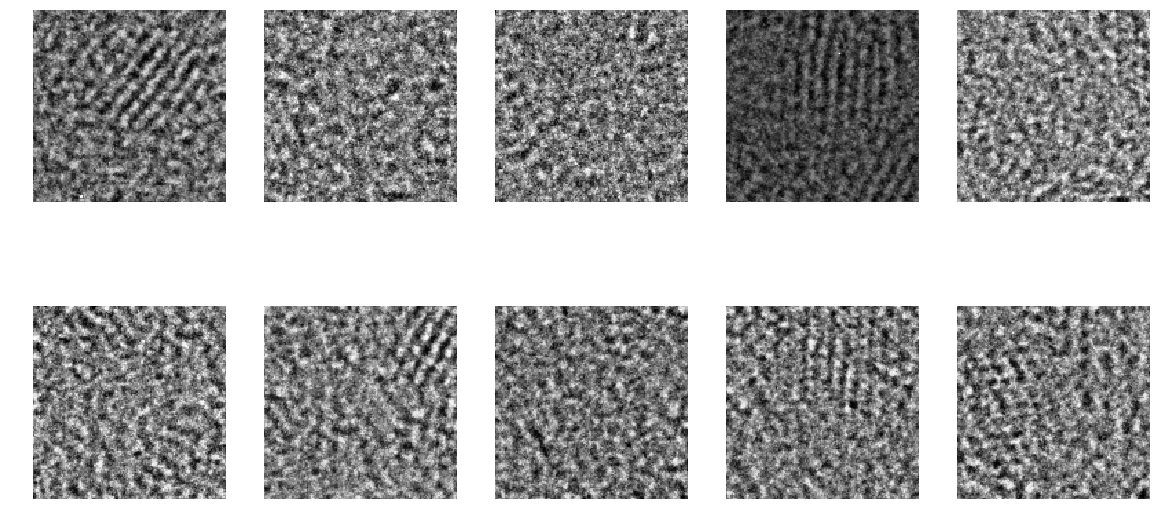

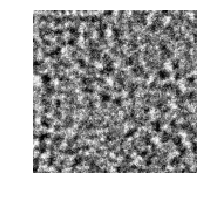

In [24]:
seg_image_files = glob(data_dir+'segmented_images/*.png')
fig, axs = plt.subplots(2,5,figsize = (20,10))
idx = 0
for row in axs:
    for ax in row:
        ax.imshow(io.imread(seg_image_files[idx]))
        ax.axis('off')
        idx += 1
fig2, ax2 = plt.subplots(1,1,figsize = (3,3))
ax2.imshow(io.imread(seg_image_files[10]))
ax2.axis('off')

Clearly the segmentation algorithm is not perfect however it did succesfully segment out four (almost 5 - clipped the edge of 2nd row, second from left) particles (top left, top second from right, and 2nd row right two images).

## Demo Classification on SFFT Segmented Images

In [7]:
model_dir = base_dir + '/rf_models/'
filename = model_dir + 'opt_random_forest.pkl'
model = joblib.load(filename)

/Users/cgroschner/anaconda/lib/python3.6/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.19.1 when using version 0.18.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/Users/cgroschner/anaconda/lib/python3.6/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 0.19.1 when using version 0.18.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [8]:
features = rf.features_unlabeled_data('/segmented_images/',data_dir, fname = 'demo_features')

In [9]:
features = pd.read_csv('demo_data/demo_features.csv')

In [17]:
predictions = model.predict(features)
for idx,predict in enumerate(predictions):
    print('image {} predicted as {}'.format(idx+1,predict))

image 1 predicted as yes
image 2 predicted as null
image 3 predicted as null
image 4 predicted as null
image 5 predicted as null
image 6 predicted as null
image 7 predicted as null
image 8 predicted as empty
image 9 predicted as null
image 10 predicted as null
image 11 predicted as null


Only images 4,8,9, and 10 are predicted correctly. I suspect that the high number of nulls predicted could be due to the fact that the sliding fft region selects regions with high accumulated spatial frequency and therefore may confuse the random forest classifier. Also the sfft segmentation method does not always put the particle directly in the center which I suspect is the core problem since two of the most important features rely on a 10x10 center cut of either the image or the local binary pattern of the image. Despite its far less than perfect performance it still correctly predicted 4/11 images, so 36% accuracy which is still better than random since there are four possible classes (yes,no,null,and empty).

## Demo Segementation via Sliding Window Method

Since the filtering and thresholding of sliding fft accumulation maps did not yield particularly good results I decided to experiment with just breaking up the images via a sliding window technique and seeing if having more randomized regions would help separate out empty space from particles. This was to test one of the hypothesizes I stated earlier that perhaps the sliding fft method is selecting regions more likely to trigger a null result.

In [8]:
sliding_image_slice(data_dir,image_name='20180227_101729F_plasma15sec_Mh370kx__0013.png')

done!


In order to not have to look through and check 256 images in this notebook I selected out a few of the regions (obviously most were empty space) and put these in a directory called 'select_slid_window' which is loaded below

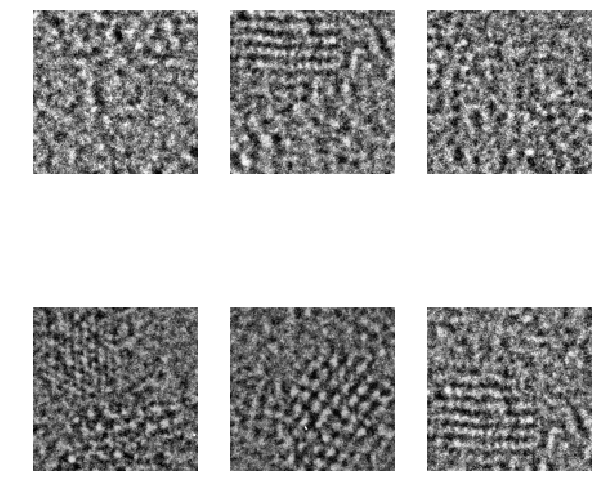

In [16]:
seg_image_files = glob(data_dir + '/select_slid_window/*.png')
fig, axs = plt.subplots(2,3,figsize = (10,10))
idx = 0
for row in axs:
    for ax in row:
        ax.imshow(io.imread(seg_image_files[idx]))
        ax.axis('off')
        idx += 1

The set presented, from top left to bottom right, should be labelled: empty, null, empty, null, yes, null.

## Demo Classification on Sliding Window Segmentation

In [4]:
model_dir = base_dir + '/rf_models/'
filename = model_dir + 'opt_random_forest.pkl'
model = joblib.load(filename)
features = rf.features_unlabeled_data('/select_slid_window/',data_dir, fname = 'demo_features_sw')
features = pd.read_csv('demo_data/demo_features_sw.csv')
print(features.shape)
predictions = model.predict(features)
for idx,predict in enumerate(predictions):
    print('image {} predicted as {}'.format(idx,predict))

/Users/cgroschner/anaconda/lib/python3.6/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.19.1 when using version 0.18.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/Users/cgroschner/anaconda/lib/python3.6/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 0.19.1 when using version 0.18.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


(6, 875)
image 0 predicted as null
image 1 predicted as null
image 2 predicted as null
image 3 predicted as null
image 4 predicted as null
image 5 predicted as null


Clearly these labels are not correct for 3/6 images. This makes me think that the sliding fft based segementation is actually a better method for preparing the data. Clearly the system prefers to predict null. From the results above, however, we know that it is not exclusively predicting null. The results from sfft segmentation and these results, show that the system is better than random. Looking at these results compared to the high performance during development (0.8 mean for cross validation with a standard deviation of 0.02 on the test data from training), points to the importance of particles being centered (which was always true for the training and testing set in development since the regions were cut out based on the known location of particles). Future work I would do to improve this system would be to change the two center cut based features to include more of the segmented image region in hopes that this would alleviate the dependence for centered images.